<a href="https://colab.research.google.com/github/Dewdiii/Forecasting-Industry-Growth-Based-on-Historical-Trade-Data-Exports-Imports-in-Sri-Lanka./blob/main/ImpExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import files
uploaded = files.upload()  # Choose ImpExp.zip

Saving ImpExp.zip to ImpExp.zip


In [3]:
import zipfile
import os

with zipfile.ZipFile("ImpExp.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")  # extracts to data/ImpExp/

In [4]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

## Build the Dataset

In [5]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_industry_data(industry):
    # List all .xlsx files inside the industry-specific folder
    all_csvs = os.listdir(data_dir.format(industry))
    all_csvs = [f for f in all_csvs if f.endswith(".xlsx")]
    all_csv_paths = [os.path.join(data_dir.format(industry), f) for f in all_csvs]

    all_data = []
    for csv in all_csv_paths:
        df = pd.read_excel(csv, sheet_name='Partner')
        df['Partner Name'] = df['Partner Name'].str.strip()
        df = df[df['Partner Name'] == 'World']
        assert len(df) == 1, f"More than one or no 'World' data found in {csv}"

        df = df[[
            'Year',
            'Export (US$ Thousand)',
            'Import (US$ Thousand)',
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)',
        ]]
        df.reset_index(drop=True, inplace=True)
        all_data.append(df)

    # Combine all files
    all_data = pd.concat(all_data).reset_index(drop=True)

    # Fill missing values with column means
    all_data.fillna(all_data.mean(), inplace=True)
    all_data = all_data.astype(float)

    # Sort by year and remove the 'Year' column
    all_data.sort_values(by='Year', inplace=True)
    all_data.drop(columns=['Year'], inplace=True)

    # Fit and save the scaler
    scaler = StandardScaler()
    scaler.fit(all_data)

    # Create model directory if it doesn't exist
    os.makedirs(os.path.dirname(model_dir.format("")), exist_ok=True)

    with open(model_dir.format(f"{industry} Scalar.pickle"), 'wb') as f:
        pickle.dump(scaler, f)

    # Scale the data
    scaled_data = pd.DataFrame(scaler.transform(all_data), columns=all_data.columns)
    return scaled_data

def make_ts_dataset(industry, selective_window=7):
    df = load_industry_data(industry)

    X, Y1, Y2 = [], [], []
    for i in range(len(df) - selective_window):
        x = df.iloc[i:i+selective_window].values
        y1 = df.iloc[i+selective_window, 0]  # Export
        y2 = df.iloc[i+selective_window, 1]  # Import

        X.append(x)
        Y1.append(y1)
        Y2.append(y2)

    return np.array(X), np.array(Y1), np.array(Y2)


### Load Sample Data

In [6]:
X, Y1, Y2 = make_ts_dataset('Agricultural Raw Materials')

print("World Data Shape : ", X.shape)
print("Export Data Shape : ", Y1.shape)
print("Import Data Shape : ", Y2.shape)

World Data Shape :  (9, 7, 7)
Export Data Shape :  (9,)
Import Data Shape :  (9,)


## Build, Train, Evaluate model

In [7]:
def build_ts_model():
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.GRU(128, return_sequences=True),
                                        tf.keras.layers.GRU(128),
                                        tf.keras.layers.Dense(1)
                                        ])

    model.compile(
                loss='mse',
                optimizer='adam',
                metrics=['mae']
                )
    return model

def train_ts_model(
                    industry,
                    epochs=100,
                    batch_size=4
                    ):
    X, Y1, Y2 = make_ts_dataset(industry)

    print(f"................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    history_imp = model_imp.fit(
                                X,
                                Y1,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    history_exp = model_exp.fit(
                                X,
                                Y2,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    return history_imp, history_exp

def plot_loss(
            industry,
            history_imp,
            history_exp
            ):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='MSE')
    plt.plot(history_imp.history['mae'], label='MAE')
    plt.title(f"Export Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='MSE')
    plt.plot(history_exp.history['mae'], label='MAE')
    plt.title(f"Import Model Loss")
    plt.legend()

    plt.suptitle(f"{industry} Model Logs")
    plt.show()

def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)

................ Training on : Agricultural Raw Materials ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.5521 - mae: 0.4788
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2114 - mae: 0.3903 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2476 - mae: 0.4174
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1530 - mae: 0.3429
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1196 - mae: 0.2694
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1076 - mae: 0.2764 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1038 - mae: 0.2633
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0823 - mae: 0.2385
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1036 - mae: 0.2557
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0981 - mae: 0.2420
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0641 - mae: 0.2086
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step -

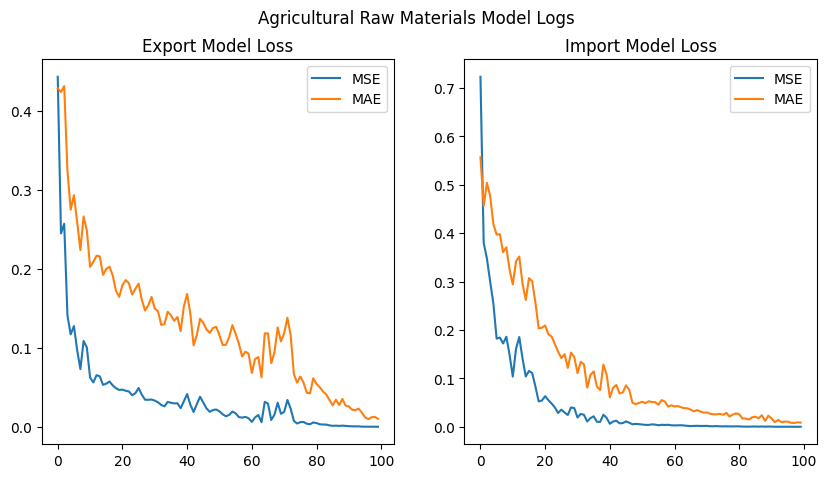

In [8]:
run_ts_model('Agricultural Raw Materials')

................ Training on : Consumer Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.5171 - mae: 0.6552
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1768 - mae: 0.3552
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1547 - mae: 0.3141
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1499 - mae: 0.2886
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1356 - mae: 0.2664
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0709 - mae: 0.2273
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0742 - mae: 0.2531
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1007 - mae: 0.2750
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1312 - mae: 0.2913
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0954 - mae: 0.2309
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0609 - mae: 0.1974
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0281 

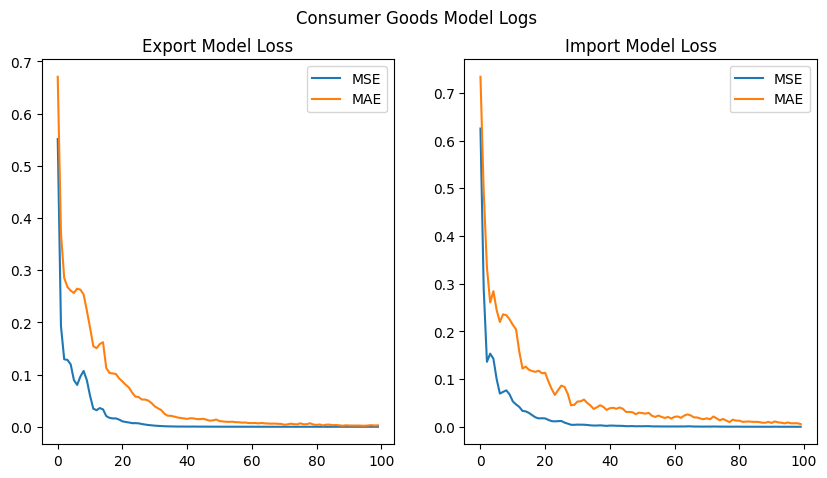

In [9]:
run_ts_model('Consumer Goods')

................ Training on : Transportation ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.9127 - mae: 0.6467
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2805 - mae: 0.7202
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8999 - mae: 0.7477
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7790 - mae: 0.7484
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7616 - mae: 0.7485
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7108 - mae: 0.6957
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6849 - mae: 0.7168
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8460 - mae: 0.7647
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7054 - mae: 0.6665
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8909 - mae: 0.7134
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9037 - mae: 0.7298
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8298 

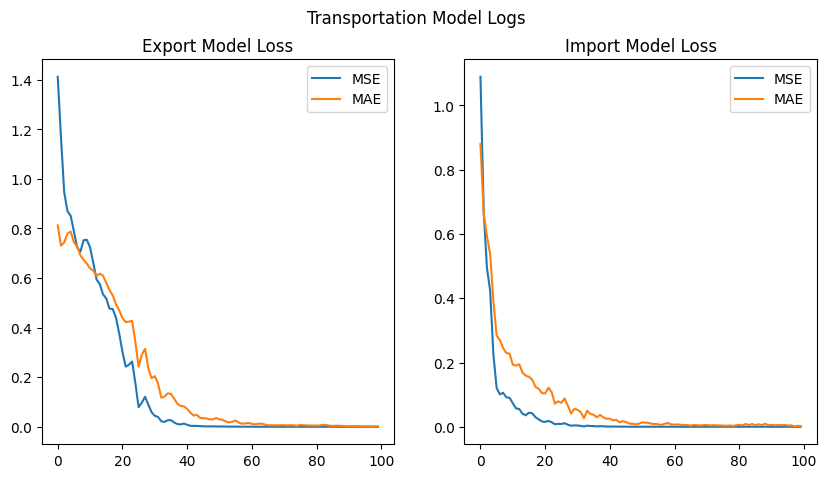

In [10]:
run_ts_model('Transportation')

................ Training on : Food Industry ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.0946 - mae: 0.7512
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3583 - mae: 0.4385
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2412 - mae: 0.3863
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1583 - mae: 0.3217
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1577 - mae: 0.3056 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0750 - mae: 0.2101
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0901 - mae: 0.2428
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0949 - mae: 0.2458
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0802 - mae: 0.2281
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0659 - mae: 0.2280
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0541 - mae: 0.2076
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0713 

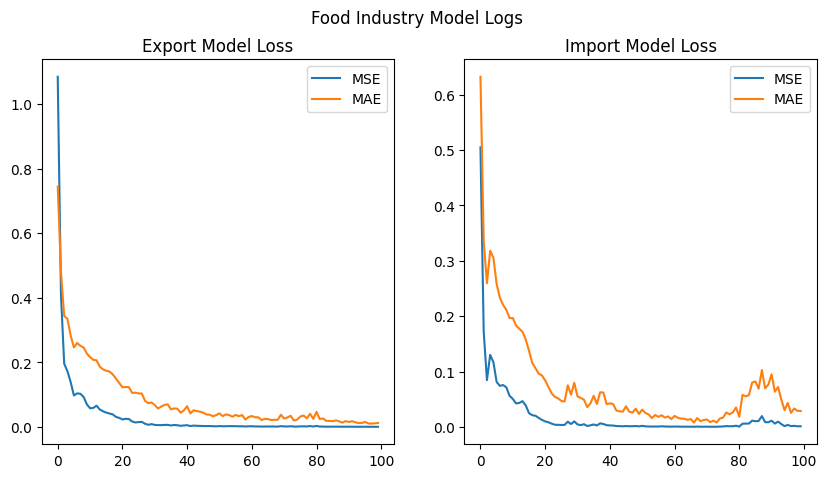

In [11]:
run_ts_model('Food Industry')

................ Training on : Capital Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.8080 - mae: 0.7199
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3294 - mae: 0.4883
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2163 - mae: 0.3920
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2184 - mae: 0.3851
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3601 - mae: 0.4856
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2919 - mae: 0.4198
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2868 - mae: 0.4585
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2643 - mae: 0.4531
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2091 - mae: 0.3930
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2185 - mae: 0.4018
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2775 - mae: 0.4433
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2349 -

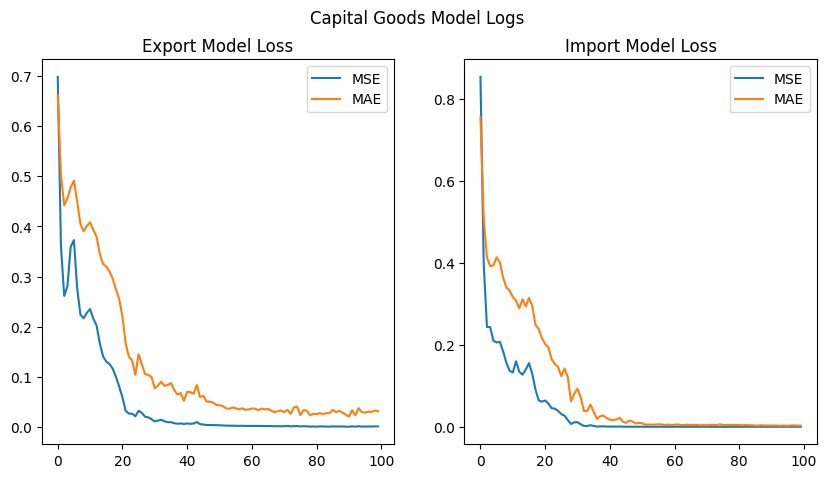

In [12]:
run_ts_model('Capital Goods')

## Inference

In [13]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

model_dict = {}

for industry in industries:
    industry_dict = {}
    industry_dict['Imp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Imp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Exp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Exp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Scaler'] = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    model_dict[industry] = industry_dict

In [14]:
def predict_ts_on_industry(
                            industry,
                            selective_window=7
                            ):
    industry_dict = model_dict[industry]
    scaler = industry_dict['Scaler']
    imp_model = industry_dict['Imp Model']
    exp_model = industry_dict['Exp Model']

    df = load_industry_data(industry)
    df_tail = df.tail(selective_window)

    x = df_tail.values
    x = x.reshape(1, x.shape[0], x.shape[1])

    p_imp = imp_model.predict(x).squeeze()
    p_imp = np.vstack([p_imp]*selective_window).squeeze()
    p_imp = np.dstack([p_imp]*selective_window).squeeze()
    p_imp = scaler.inverse_transform(p_imp)
    p_imp = p_imp[0][0]

    p_exp = exp_model.predict(x).squeeze()
    p_exp = np.vstack([p_exp]*selective_window).squeeze()
    p_exp = np.dstack([p_exp]*selective_window).squeeze()
    p_exp = scaler.inverse_transform(p_exp)
    p_exp = p_exp[0][0]

    df_tail_inv = scaler.inverse_transform(df_tail)
    imp_data = df_tail_inv[:, 0]
    exp_data = df_tail_inv[:, 1]

    avg_imp = np.mean(imp_data)
    avg_exp = np.mean(exp_data)

    # percentage of change
    p_imp = ((p_imp - avg_imp) / avg_imp) * 100
    p_exp = ((p_exp - avg_exp) / avg_exp) * 100

    return p_imp, p_exp

In [15]:
p_imp, p_exp = predict_ts_on_industry('Agricultural Raw Materials')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Predicted Export Change : 17.05%
Predicted Import Change : 16.68%
